In [8]:
# standard library
import os

import pandas as pd
import seaborn as sns
import numpy as np
from highstreets.data import make_dataset as mhsd
from dotenv import load_dotenv, find_dotenv
import matplotlib.pyplot as plt

import numpyro
from numpyro.infer import MCMC, NUTS, Predictive, init_to_feasible
import numpyro.distributions as dist
from jax import random

# import jax.numpy as jnp
import arviz as az

import dill

assert numpyro.__version__.startswith("0.9.2")

load_dotenv(find_dotenv())

YOY_FILE = os.environ.get("YOY_FILE")
PROFILE_FILE = os.environ.get("PROFILE_FILE")
PROJECT_ROOT = os.environ.get("PROJECT_ROOT")

%load_ext autoreload
%autoreload 2

sns.set_theme(style="darkgrid")
sns.set_context("notebook")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load mastercard spend data along with high street profiles and setup data arrays and time vectors for convenience


In [3]:
hsp = pd.read_excel(PROFILE_FILE)
hsd_yoy = pd.read_csv(YOY_FILE, parse_dates=["week_start"])

# some important dates
nb_dates = pd.to_datetime(
    [
        "2020-03-24",  # first lockdown starts
        "2020-06-15",  # shops reopen
        "2020-11-05",  # second lockdown starts
        "2020-12-02",  # back to 'tier 2' (i.e. partial reopening)
        "2021-01-05",  # third lockdown starts
        "2021-04-12",  # shops reopen
    ]
)

# average weekday and weekend expenditure (should probably relax this
# later - no need to lose information)
# hsd_yoy_minimal = mhsd.get_minimal_df(hsd_yoy, "yoy_").dropna(how="any", axis="rows")
# hsd_yoy_minimal = mhsd.avg_retail_wd_we(hsd_yoy, "yoy_").dropna(how="any", axis="rows")

hsd_yoy_minimal = mhsd.stack_retail_we_wd(hsd_yoy, "yoy_").dropna(
    how="any", axis="rows"
)

dates_2020 = ("2020-04-15", "2020-10-31")
dates_2020_full = ("2020-01-01", "2020-12-31")
dates_2021 = ("2021-02-12", "2021-08-31")
dates_full = ("2020-01-01", "2021-12-31")

data_2020 = mhsd.extract_data_array(hsd_yoy_minimal, dates_2020, "txn_amt")
data_2021 = mhsd.extract_data_array(hsd_yoy_minimal, dates_2021, "txn_amt")
data_2020_full = mhsd.extract_data_array(hsd_yoy_minimal, dates_2020_full, "txn_amt")
data_full = mhsd.extract_data_array(hsd_yoy_minimal, dates_full, "txn_amt")

start_times = {"2020": "2020-04-01", "2021": "2021-04-12", "full": "2020-04-01"}
tvecs = {"2020": data_2020.index, "2021": data_2021.index, "full": data_full.index}
arrays = {
    "2020": np.transpose(data_2020.to_numpy()),
    "2021": np.transpose(data_2021.to_numpy()),
    "full": np.transpose(data_full.to_numpy()),
}

### Set up data to be used in hierarcical regressions

In [4]:
predictors = [
    "percentage of commercial addresses (%)",
    "total estimated number of home workers",
    "Sum_y2019_07wd",
]
full_data = (
    hsd_yoy_minimal.join(
        hsp[["highstreet_id"] + predictors],
        on="highstreet_id",
        how="left",
        lsuffix="_left",
        rsuffix="_right",
    )
    .drop(["highstreet_id_right", "txn_cnt"], axis=1)
    .rename(columns={"highstreet_id_left": "highstreet_id"})
)
full_data["weeks_since_start"] = (
    full_data.index - pd.to_datetime(nb_dates[0])
) / pd.Timedelta(1, "W")
train = full_data.loc[nb_dates[0] : nb_dates[1]]
train.head()

,period_start,highstreet_id,highstreet_name,txn_amt,we_wd,percentage of commercial addresses (%),total estimated number of home workers,Sum_y2019_07wd,weeks_since_start
period_start,,,,,,,,,
2020-03-28,2020-03-28,618,"Finchley Road, West Hampstead.",0.691,we,NaN,NaN,NaN,0.571429
2020-03-28,2020-03-28,211,"Essex Road, Islington",0.873,we,5.378832,2888.0,1668.602019,0.571429
2020-03-28,2020-03-28,210,"Southgate Road, De Beauvoir Town",0.000,we,6.573913,10486.0,1328.581381,0.571429
2020-03-28,2020-03-28,209,"New North Road, East Road, Hoxton",1.058,we,5.865028,16261.0,2583.312951,0.571429
2020-03-28,2020-03-28,208,"Kingsland Road, Haggerston",0.268,we,5.201156,12652.0,1823.598610,0.571429


### Define hierarchical regression model

In [5]:
def model(highstreet_id, weeks, hs_obs=None):
    mu_a = numpyro.sample("mu_a", dist.Normal(0.0, 1.0))
    sigma_a = numpyro.sample("sigma_a", dist.HalfNormal(1.0))
    mu_b = numpyro.sample("mu_b", dist.Normal(0.0, 1.0))
    sigma_b = numpyro.sample("sigma_b", dist.HalfNormal(1.0))

    unique_hs_ids = np.unique(highstreet_id)
    n_hs = len(unique_hs_ids)

    with numpyro.plate("plate_i", n_hs):
        a = numpyro.sample("a", dist.Normal(mu_a, sigma_a))
        b = numpyro.sample("b", dist.Normal(mu_b, sigma_b))

    sigma = numpyro.sample("sigma", dist.HalfNormal(1.0))
    hs_est = a[highstreet_id] + b[highstreet_id] * weeks

    with numpyro.plate("data", len(highstreet_id)):
        numpyro.sample("obs", dist.Normal(hs_est, sigma), obs=hs_obs)

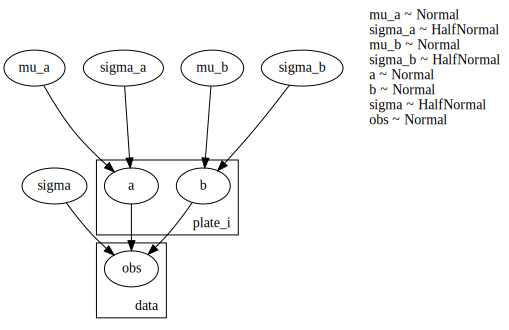

In [6]:
hs_obs = train["txn_amt"].values
weeks = train["weeks_since_start"].values
highstreet_id = train["highstreet_id"].values

graph = numpyro.render_model(
    model, model_args=(highstreet_id, weeks), render_distributions=True
).unflatten()

graph.render(
    filename=PROJECT_ROOT
    + "/reports/figures/hierarchical_model_graphs/simple_regression_2020_pooled"
)

graph

In [7]:
# def model(highstreet_id, weeks, predictors, hs_obs=None):
#     mu_gamma_a = numpyro.sample(
#         "mu_gamma_a",
#         dist.MultivariateNormal(
#             loc=0.0,
#             covariance_matrix=jnp.eye(predictors.shape[0]),
#         ),
#     )
#     sigma_a = numpyro.sample("sigma_a", dist.HalfNormal(1.0))
#     mu_gamma_b = numpyro.sample("mu_gamma_b", dist.MultivariateNormal(0.0))
#     sigma_b = numpyro.sample("sigma_b", dist.HalfNormal(1.0))

#     unique_hs_ids = np.unique(highstreet_id)
#     n_hs = len(unique_hs_ids)

#     with numpyro.plate("plate_i", n_hs):
#         gamma_a = numpyro.sample(
#             "gamma_a",
#             dist.MultivariateNormal(
#                 loc=mu_gamma_a,
#                 covariance_matrix=sigma_a * jnp.eye(),
#             ),
#         )
#         b = numpyro.sample("b", dist.Normal(mu_b, sigma_b))

#     sigma = numpyro.sample("sigma", dist.HalfNormal(1.0))
#     hs_est = a[highstreet_id] + b[highstreet_id] * weeks

#     with numpyro.plate("data", len(highstreet_id)):
#         numpyro.sample("obs", dist.Normal(hs_est, sigma), obs=hs_obs)

### Sample from the posterior

In [149]:
nuts_kernel = NUTS(model, init_strategy=init_to_feasible())

mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=1000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, highstreet_id, weeks, hs_obs=hs_obs)
posterior_samples = mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [10:52<00:00,  4.60it/s, 1023 steps of size 5.81e-04. acc. prob=0.83]


#### Save the model samples

In [ ]:
dill_file = PROJECT_ROOT + "/models/bayesian/posterior_samples_basic.pkl"
with open(dill_file, "wb") as f:
    dill.dump(
        posterior_samples,
        f,
    )


dill_file = PROJECT_ROOT + "/models/bayesian/mcmc_basic.pkl"
with open(dill_file, "wb") as f:
    dill.dump(
        mcmc,
        f,
    )

### Load previous samples

In [ ]:
dill_file = PROJECT_ROOT + "models/bayesian/posterior_samples_basic.pkl"
with open(dill_file, "rb") as f:
    posterior_samples = dill.load(f)

dill_file = PROJECT_ROOT + "models/bayesian/mcmc_basic.pkl"
with open(dill_file, "rb") as f:
    mcmc = dill.load(f)

### Trace plot for centered model

array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'mu_a'}>,
        <AxesSubplot:title={'center':'mu_a'}>],
       [<AxesSubplot:title={'center':'mu_b'}>,
        <AxesSubplot:title={'center':'mu_b'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>],
       [<AxesSubplot:title={'center':'sigma_a'}>,
        <AxesSubplot:title={'center':'sigma_a'}>],
       [<AxesSubplot:title={'center':'sigma_b'}>,
        <AxesSubplot:title={'center':'sigma_b'}>]], dtype=object)

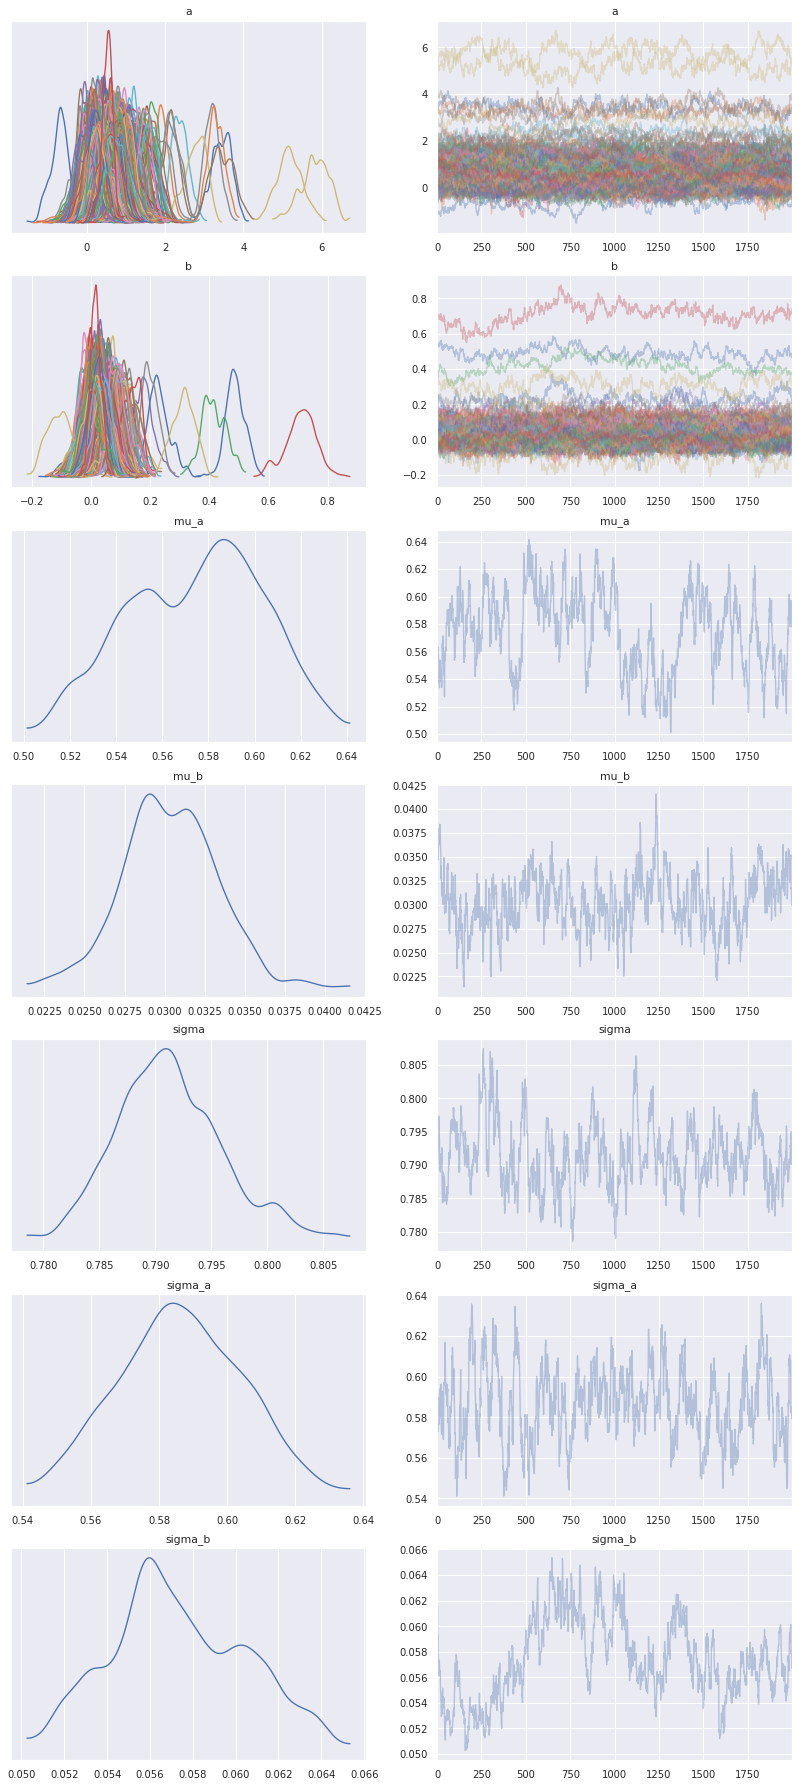

In [151]:
data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True, figsize=(14, 32))

### Examine model output

In [152]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      a[0]      0.62      0.65      0.62     -0.52      1.58     23.13      1.00
      a[1]      0.09      0.26      0.05     -0.30      0.51     17.58      1.13
      a[2]      0.16      0.26      0.15     -0.26      0.60     35.74      1.01
      a[3]      0.03      0.26      0.05     -0.37      0.46      6.05      1.48
      a[4]      1.08      0.22      1.06      0.73      1.46     50.00      1.00
      a[5]      0.22      0.25      0.22     -0.20      0.59     34.09      1.09
      a[6]      0.40      0.22      0.38      0.07      0.77     25.93      1.00
      a[7]      0.21      0.22      0.20     -0.10      0.63     16.62      1.04
      a[8]      0.54      0.24      0.54      0.17      0.94     24.14      1.01
      a[9]      0.68      0.25      0.70      0.31      1.11     10.03      1.01
     a[10]      0.55      0.26      0.55      0.21      1.05     22.03      1.11
     a[11]      0.27      0

### Compare predictions to data

In [173]:
weeks_pred = train[train["highstreet_id"] == 1]["weeks_since_start"]
pred_template = []
for i in np.unique(train["highstreet_id"]):
    df = pd.DataFrame(columns=["highstreet_id", "weeks"])
    df["weeks"] = weeks_pred
    df["highstreet_id"] = i
    pred_template.append(df)
pred_template = pd.concat(pred_template, ignore_index=True)

highstreet_id = pred_template["highstreet_id"].values
weeks = pred_template["weeks"].values
predictive = Predictive(model, posterior_samples, return_sites=["sigma", "obs"])
samples_predictive = predictive(random.PRNGKey(0), highstreet_id, weeks, None)


df_act_pred = pd.DataFrame(
    columns=["highstreet_id", "weeks_since_start", "txn_amt_pred", "sigma"]
)
df_act_pred["highstreet_id"] = pred_template["highstreet_id"]
df_act_pred["weeks_since_start"] = pred_template["weeks"]
df_act_pred["txn_amt_pred"] = samples_predictive["obs"].T.mean(axis=1)
df_act_pred["sigma"] = samples_predictive["obs"].T.std(axis=1)
df_act_pred["hs_inf"] = df_act_pred["txn_amt_pred"] - df_act_pred["sigma"]
df_act_pred["hs_sup"] = df_act_pred["txn_amt_pred"] + df_act_pred["sigma"]
df_act_pred = pd.merge(
    df_act_pred,
    train[["highstreet_id", "weeks_since_start", "txn_amt"]],
    how="left",
    on=["highstreet_id", "weeks_since_start"],
)
df_act_pred = df_act_pred.rename(columns={"txn_amt": "txn_amt_true"})
df_act_pred.head()

,highstreet_id,weeks_since_start,txn_amt_pred,sigma,hs_inf,hs_sup,txn_amt_true
0,1,0.571429,0.098353,0.816104,-0.717751,0.914458,0.020
1,1,0.857143,0.088817,0.824594,-0.735777,0.913411,0.051
2,1,1.571429,0.070010,0.825633,-0.755623,0.895644,0.027
3,1,1.857143,0.078705,0.798480,-0.719775,0.877185,0.048
4,1,2.571429,0.071056,0.796640,-0.725584,0.867695,0.053


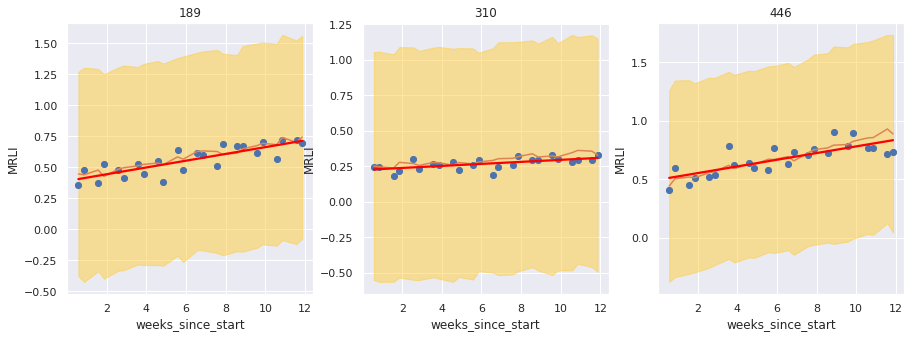

In [184]:
def chart_highstreet_with_predictions(highstreet_id, ax):
    data = df_act_pred[df_act_pred["highstreet_id"] == highstreet_id]
    x = data["weeks_since_start"]
    ax.set_title(highstreet_id)
    ax.plot(x, data["txn_amt_true"], "o")
    ax.plot(x, data["txn_amt_pred"])
    ax = sns.regplot(
        x=x, y=data["txn_amt_true"], ax=ax, ci=None, line_kws={"color": "red"}
    )
    ax.fill_between(x, data["hs_inf"], data["hs_sup"], alpha=0.5, color="#ffcd3c")
    ax.set_ylabel("MRLI")


f, axes = plt.subplots(1, 3, figsize=(15, 5))
hs_plot = [189, 310, 446]
for i, id in enumerate(hs_plot):
    chart_highstreet_with_predictions(id, axes[i])

In [9]:
train

,period_start,highstreet_id,highstreet_name,txn_amt,we_wd,percentage of commercial addresses (%),total estimated number of home workers,Sum_y2019_07wd,weeks_since_start
period_start,,,,,,,,,
2020-03-28,2020-03-28,618,"Finchley Road, West Hampstead.",0.691,we,NaN,NaN,NaN,0.571429
2020-03-28,2020-03-28,211,"Essex Road, Islington",0.873,we,5.378832,2888.0,1668.602019,0.571429
2020-03-28,2020-03-28,210,"Southgate Road, De Beauvoir Town",0.000,we,6.573913,10486.0,1328.581381,0.571429
2020-03-28,2020-03-28,209,"New North Road, East Road, Hoxton",1.058,we,5.865028,16261.0,2583.312951,0.571429
2020-03-28,2020-03-28,208,"Kingsland Road, Haggerston",0.268,we,5.201156,12652.0,1823.598610,0.571429
...,...,...,...,...,...,...,...,...,...
2020-06-15,2020-06-15,398,"Ilford Lane, Ilford.",0.894,wd,6.137738,20716.0,5087.198929,11.857143
2020-06-15,2020-06-15,397,"The Avenue, Highams Park.",1.152,wd,8.462796,4070.0,1152.089300,11.857143
2020-06-15,2020-06-15,396,"Hertford Road, Enfield Highway",0.763,wd,5.203469,6044.0,4032.868169,11.857143


In [ ]:
def model_w_regressors(highstreet_id, weeks, hs_obs=None):
    mu_a = numpyro.sample("mu_a", dist.Normal(0.0, 1.0))
    sigma_a = numpyro.sample("sigma_a", dist.HalfNormal(1.0))
    mu_b = numpyro.sample("mu_b", dist.Normal(0.0, 1.0))
    sigma_b = numpyro.sample("sigma_b", dist.HalfNormal(1.0))

    unique_hs_ids = np.unique(highstreet_id)
    n_hs = len(unique_hs_ids)

    with numpyro.plate("plate_i", n_hs):
        a = numpyro.sample("a", dist.Normal(mu_a, sigma_a))
        b = numpyro.sample("b", dist.Normal(mu_b, sigma_b))

    sigma = numpyro.sample("sigma", dist.HalfNormal(1.0))
    hs_est = a[highstreet_id] + b[highstreet_id] * weeks

    with numpyro.plate("data", len(highstreet_id)):
        numpyro.sample("obs", dist.Normal(hs_est, sigma), obs=hs_obs)